# Import

In [24]:
import pandas as pd
import sys
sys.path.insert(1, 'scripts/')
from gtfparse import read_gtf
import seaborn as sns
import matplotlib.pyplot as plt
import mygene
from matplotlib_venn import venn2, venn3, venn3_circles
import numpy as np
import os
import utils
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import cm
import textwrap

from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from scripts.genes_ncbi_human_proteincoding import GENEID2NT as GeneID2nt_hum



In [2]:

# Define the parameters used to create the plots
rc = {'figure.figsize':(15,10),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20,    
      'font.sans-serif': 'Arial',
      'font.family': 'sans-serif',
      'svg.fonttype' : 'none' }


# A. Transcript length plot

/home/tabear/anaconda3/envs/plots/lib/python3.11/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/tabear/anaconda3/envs/plots/lib/python3.11/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcripts', 'transcript_id', 'similar_reference_id', 'alternatives', 'exons', 'Canonical', 'exon']
/tmp/ipykernel_845339/1220258157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isoq

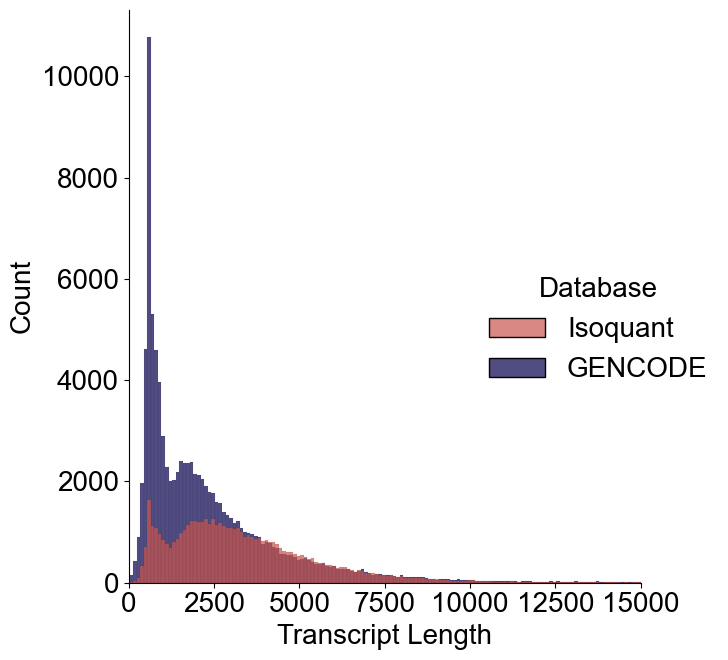

In [5]:
# Load the isoquant gtf file
isoquant_gtf = read_gtf('data/transcriptomics/isoquant_aln.sorted.transcript_models.gtf')

# Sum up length of exons to get the transcript length
isoquant_exons = isoquant_gtf[isoquant_gtf['feature'] == 'exon']
isoquant_exons['length'] = isoquant_exons['end'] - isoquant_exons['start'] + 1
isoquant_transcript_length = isoquant_exons.groupby(by='transcript_id')['length'].sum()

# Create a dataframe with all transcripts and add the length
isoquant_transcripts = isoquant_gtf[isoquant_gtf['feature'] == 'transcript']
isoquant_length_df = pd.merge(isoquant_transcripts, isoquant_transcript_length, on='transcript_id')

# Load the length of reference transcripts
reference_transcripts = pd.read_csv('biomart/proteincoding.txt', sep = '\t')

# Load the protein coding genes
with open('biomart/proteincoding_genes.txt', 'r') as file:
	protein_coding_genes = file.read().splitlines()
        
# Filter the isoquant output for protein coding genes
isoquant_protein_coding = isoquant_length_df[isoquant_length_df['gene_id'].str.split('.').str[0].isin(protein_coding_genes)]

# Create a combined dataframe with the lenght of isoquant and reference transcripts
transcript_length = []
for i in isoquant_protein_coding['length']:
    transcript_length.append(['isoquant', i])
for i in reference_transcripts['Transcript length (including UTRs and CDS)']:
    transcript_length.append(['reference', i])
df = pd.DataFrame(transcript_length, columns=['database', 'length']) 
df = df.rename(columns = {'length': 'Transcript Length', 'database': 'Database'})
df = df.replace({'Database': {'isoquant':'Isoquant', 'reference':'GENCODE'}})

# Create the plot
plt.rcParams.update(rc)
ax = sns.displot(data=df, x='Transcript Length', hue='Database', palette={'Isoquant': '#cb564f', 'GENCODE': '#07004D'}, alpha=0.7 , height=7)
sns.move_legend(ax, loc= 'center right', bbox_to_anchor=(0.8, 0.5))
plt.xlim(0, 15000)
#plt.savefig('figures/transcript_length_plot.svg', dpi=300, bbox_inches='tight')
plt.show()

# B. Number of isoforms per gene

Number of genes with a transcript 16277
Number of novel genes with a transcript 470
Number of reference genes with a transcript 15807


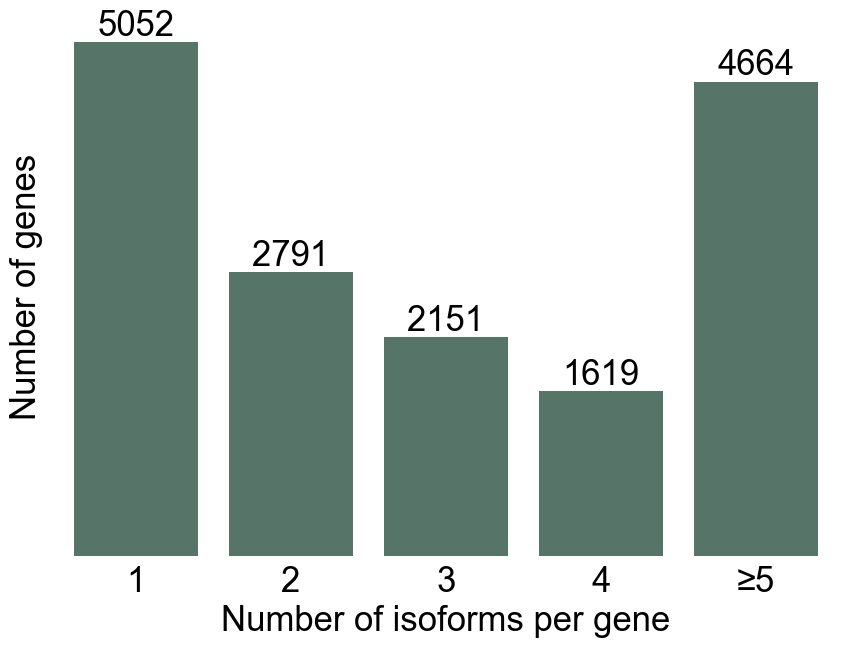

In [6]:
# Filter the isoquant gtf for genes
isoquant_genes = isoquant_gtf[isoquant_gtf['feature'] == 'gene']

print('Number of genes with a transcript {}'.format(isoquant_genes['gene_id'].nunique()))
novel_genes = isoquant_genes[isoquant_genes['gene_id'].str.contains('novel')]
print('Number of novel genes with a transcript {}'.format(novel_genes['gene_id'].nunique()))
known_genes = isoquant_genes[isoquant_genes['gene_id'].str.contains('ENSG')]
print('Number of reference genes with a transcript {}'.format(known_genes['gene_id'].nunique()))

# Count the number of transcripts per gene
transcripts_per_gene = isoquant_genes.transcripts.value_counts()
# Combine all genes with 5 or more transcripts
transcripts_per_gene[4] = transcripts_per_gene[4:].sum()
transcripts_per_gene = transcripts_per_gene[:5]

rc = {'figure.figsize':(10,7),
      'font.size' : 25}
plt.rcParams.update(rc)

p = sns.barplot(y=transcripts_per_gene, x=['1','2','3','4','≥5'], palette=['#567568'], saturation = 1)
p.set(ylabel='Number of genes')
p.set(xlabel='Number of isoforms per gene')
# Remove y-axis labels
p.set(yticklabels=[])
# Add values to bars
p.bar_label(p.containers[0], label_type='edge', color = 'black')
# Remove x and y ticks
p.tick_params(left=False, bottom=False)
# Remove black x and y axis line
sns.despine(bottom = True, left = True)
#plt.savefig('figures/number_isoforms_per_gene.svg', dpi=300, bbox_inches="tight")
plt.show()

# C. Protein-coding vs non-coding

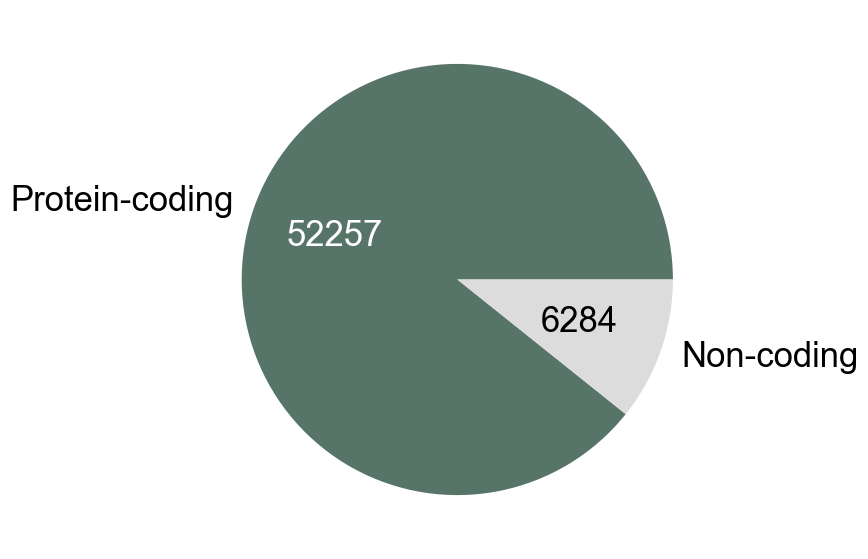

In [16]:
# Load the isoform classification data
isoquant_isoforms = pd.read_csv('data/transcriptomics/isoquant_classification.tsv', sep = '\t')

# Check which isoforms belong to protein-coding genes
isoquant_isoforms['protein_coding'] = isoquant_isoforms.associated_gene.isin(protein_coding_genes)

rc = {'figure.figsize':(7,7)}
plt.rcParams.update(rc)

def absolute_value(val):
    a  = np.round(val/100.*isoquant_isoforms.protein_coding.value_counts().sum())
    return int(a)

# Create the plot
ax = isoquant_isoforms.protein_coding.value_counts().plot.pie(autopct=absolute_value, colors= ['#567568', 'gainsboro'], labels = ['Protein-coding', 'Non-coding'])
for text, color in zip(ax.texts, ['black', 'white']):
    text.set_color(color)
ax.axes.get_yaxis().set_visible(False)
#plt.savefig('figures/protein_coding.svg', dpi = 300,  bbox_inches='tight')
plt.show()

# D. GO enrichment analysis

Adapted from:

https://github.com/tanghaibao/goatools/blob/main/notebooks/goea_nbt3102_all_study_genes.ipynb

https://github.com/mousepixels/sanbomics_scripts

In [26]:
gene_expression = isoquant_isoforms.groupby('gene_symbol')['FL_count'].sum()

# Sort summed counts in descending order and get the sorted gene names
most_expressed_genes = gene_expression.sort_values(ascending=False).index.tolist()

!python scripts/ncbi_gene_results_to_python.py -o data/go/genes_ncbi_human_proteincoding.py data/go/gene_result.txt

# initialise variables 
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

# Create a mapper to map gene symbols to gene ids
mapper = {}
for key in GeneID2nt_hum:
    mapper[GeneID2nt_hum[key].Symbol] = GeneID2nt_hum[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

#run one time to initialize

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hum.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    
temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

# perform the GO analysis on a list of test genes
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO

# Run the GO analysis on the 300 most expressed genes
go_result = go_it(most_expressed_genes[:300])

# Create the plot
# Calculate the percentage of genes associated with the GO term that are enriched
go_result['per'] = go_result.n_genes/go_result.n_go
# Only select the 10 most significant hits for the plot
go_result = go_result[0:10]

cmap = sns.blend_palette(['#567568', '#E3E9C2'], as_cmap = True)
norm = matplotlib.colors.Normalize(vmin = go_result.p_corr.min(), vmax = go_result.p_corr.max())
mapper = cm.ScalarMappable(norm = norm, cmap = cmap)

plt.rcParams.update(rc)
fig, ax = plt.subplots()
ax = sns.barplot(data = go_result, x = 'per', y = 'term', palette = mapper.to_rgba(go_result.p_corr.values), saturation=1)
#ax.set_yticklabels([textwrap.fill(e,25) for e in df['term']])
fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap))
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
ax.set(ylabel=None)
ax.set(xlabel='Gene ratio')
#plt.savefig('figures/GO_enrichment.svg', dpi=300, bbox_inches='tight')
plt.show()

**ERROR-NOT FOUND: data/go/gene_result.txt
  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms
HMS:0:00:11.768737 343,513 annotations, 20,757 genes, 18,851 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
 82% 16,989 of 20,652 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,125 of 20,652 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,580 of 20,652 population items found in association
input genes: 300
mapped genes: 295

Runing BP Ontology Analysis: current study set of 295 IDs.
 97%    286 of    295 study items found in association
100%    295 of    295 study items found in population(20652)
Calculating 12,298 uncorrected p-values using fisher_scipy_stats


# E. Overlap of individual transcriptomes

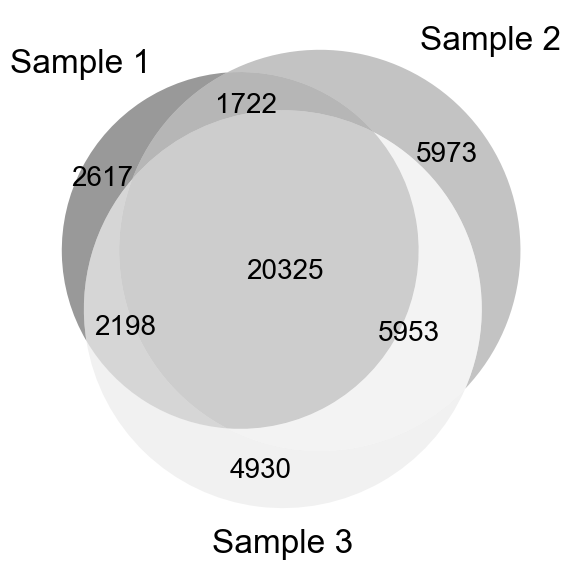

In [8]:
counts = pd.read_csv('/mnt/xomics/tabear/atlas_paper/transcriptome/isoquant/00_aln.sorted/00_aln.sorted.transcript_grouped_counts.tsv', sep = '\t')
counts = counts.rename(columns = {'s1':'Sample 1', 's2':'Sample 2', 's3': 'Sample 3'})
utils.overlap3(counts, 'overlap_transcripts', 'Sample 1', 'Sample 2', 'Sample 3', size = (7,7))